# Correcting distortion in SAED data #

## A NOTE BEFORE STARTING ##

Since the ``emicroml`` git repository tracks this notebook under its original
basename ``correcting_distortion_in_saed_data.ipynb``, we recommend that you
copy the original notebook and rename it to any other basename that is not one
of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``emicroml`` repository. For example, you could rename it
``correcting_distortion_in_saed_data.ipynb``. This way you can explore the
notebook by executing and modifying cells without changing the original
notebook, which is being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Loading and visualizing the SAED and CBED patterns](#Loading-and-visualizing-the-SAED-and-CBED-patterns)
- [Estimating the distortion in the CBED pattern](#Estimating-the-distortion-in-the-CBED-pattern)
- [Correcting the distortion in the SAED pattern](#Correcting-the-distortion-in-the-SAED-pattern)
- [Assessing the accuracy of the distortion correction](#Assessing-the-accuracy-of-the-distortion-correction)

## Import necessary modules ##

In [1]:
# For pattern matching.
import re

# For listing files and subdirectories in a given directory, and for renaming
# directories.
import os

# For adding new directories in which to search for local Python modules. Only
# used at the end of the current notebook cell.
import sys



# For general array handling.
import numpy as np

# For creating and plotting figures.
import hyperspy.api as hs



# For loading ML models for distortion estimation in CBED.
import emicroml.modelling.cbed.distortion.estimation

# For visualizing some data and performing some fittings. Users need not focus
# on the implementation details of this module in order to follow the logic of
# each cell in the remainder of this notebook. Morevoer, users need not import 
# this module for their own applications of ``emicroml``.
sys.path.insert(0, "..")
import helpers.for_correcting_distortion_in_saed_data as helpers

## Introduction ##

In this notebook, we show how one can use one of the machine learning (ML)
models that are trained as a result of executing the "action" described in the
page [Training machine learning
models](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/train_ml_model_set.html)
to correct distortion in selected area electron diffraction (SAED)
data. Strictly speaking, each ML model is trained to estimate distortion in
convergent beam electron diffraction (CBED) patterns. However, by exploiting the
fact that distortions predominantly come from post-specimen lenses,
e.g. projection lenses, we can estimate and correct distortion in SAED data as
follows:

1. Collect the target experimental SAED data;
2. Modify only pre-specimen lenses to produce CBED data;
3. Use a ML model to estimate distortion field in CBED data;
4. Correct distortion in SAED data using distortion field from step 3.

We demonstrate steps 3 and 4 using pre-collected experimental SAED and CBED
patterns of a calibration sample of single-crystal Au oriented in the \[100\]
direction. This experimental data was collected on a modified Hitachi SU9000
scanning electron microscope operated at 20 keV.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    torch
    jupyter
    emicroml

Before installing `emicroml`, it is recommended that users install `torch`
(i.e. `PyTorch`) in the same environment that they intend to install `emicroml`
according to the instructions given
[here](https://pytorch.org/get-started/locally/) for their preferred `PyTorch`
installation option. After installing `torch`, users can install the remaining
libraries by running the following command in a terminal:

    pip install emicroml jupyter

The `emicroml` repository contains a script located at
`<root>/default_env_setup_for_slurm_jobs.sh` that will attempt to create a
virtual environment, then activate it, and then install all the libraries
required to run all of the examples in said repository, when executed with
appropriately chosen command line arguments. As an alternative to the manual
installation procedure above, users can try the automated approach that involves
executing the aforementioned script. See [this
page](https://mrfitzpa.github.io/emicroml/examples/prerequisites_for_execution_without_slurm.html)
for instructions on how to do so.

A subset of the output that results from performing the "actions" mentioned at
the beginning of this section is required to execute the cells in this notebook
as intended. One can obtain this subset of output by executing said actions,
however this requires significant computational resources, including significant
walltime. Alternatively, one can copy this subset of output from a Federated
Research Data Repository (FRDR) dataset by following the instructions given on
[this
page](https://mrfitzpa.github.io/emicroml/examples/modelling/cbed/distortion/estimation/copying_subset_of_output_from_frdr_dataset.html).
For this particular notebook, the only file that one would need to copy from the
FRDR dataset is:

    <frdr_dataset_root>/emicroml/examples/modelling/cbed/distortion/estimation/data/ml_models/ml_model_1/ml_model_at_lr_step_<step_count>.pth

where `<frdr_dataset_root>` is the root of the FRDR dataset, and `<step_count>`
is an integer.

You can find the documentation for the `emicroml` library
[here](https://mrfitzpa.github.io/emicroml/_autosummary/emicroml.html). It is
recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `emicroml` that they are currently using.**

The last module that we imported above (i.e. the module with the alias
`helpers`) contains helper functions that are used throughout the remainder of
the notebook, specifically to visualize some data and to perform some
fittings. It is not essential that users know the implementation details of
these helper functions in order to follow the logic of each cell in the
remainder of this notebook. Moreover, users need not import this module for
their own applications of `emicroml`. That being said, if any users are
interested in the implementation details, they can find them in the file
`<root>/examples/modelling/cbed/distortion/estimation/helpers/for_correcting_distortion_in_saed_data.py`.

## Loading and visualizing the SAED and CBED patterns ##

Let's load and visualize the target SAED pattern:

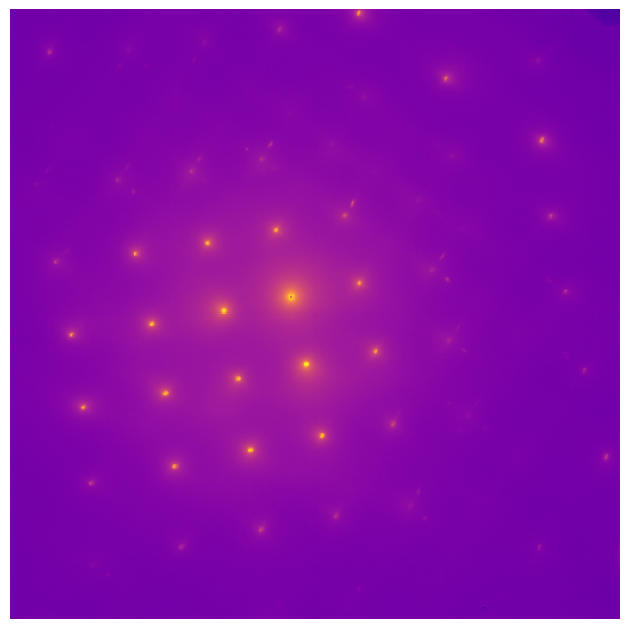

In [2]:
path_to_data_dir = "../data"
filename = (path_to_data_dir 
            + "/for_demo_of_distortion_correction_in_saed_data"
            + "/distorted_saed_pattern.npy")

kwargs = {"file": filename}
distorted_saed_pattern_image = np.load(**kwargs)

kwargs = {"data": distorted_saed_pattern_image}
distorted_saed_pattern_signal = hs.signals.Signal2D(**kwargs)



kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
distorted_saed_pattern_signal.plot(**kwargs)

This SAED pattern is subject to optical distortion which we want to correct. To
do this, keeping the sample inside, we modify only the pre-specimen lenses to
produce a CBED pattern which should be subject approximately to the same
distortion.

Let's load and visualize the target CBED pattern:

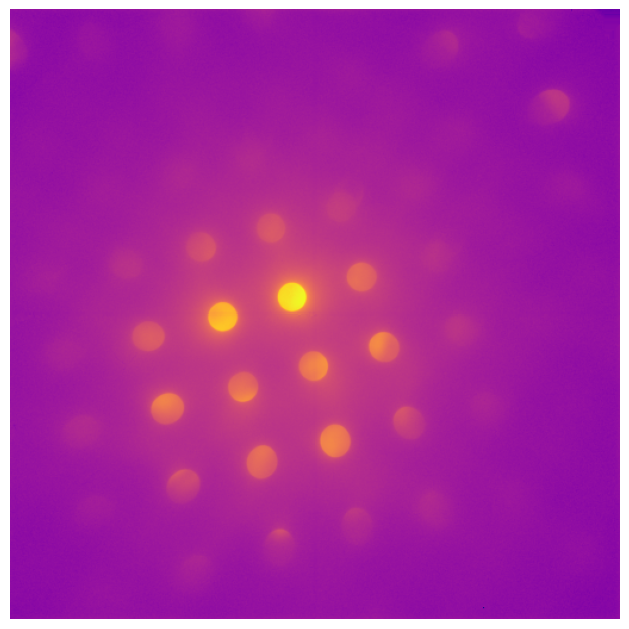

In [3]:
filename = (path_to_data_dir 
            + "/for_demo_of_distortion_correction_in_saed_data"
            + "/distorted_cbed_pattern.npy")

kwargs = {"file": filename}
distorted_cbed_pattern_image = np.load(**kwargs)

kwargs = {"data": distorted_cbed_pattern_image}
distorted_cbed_pattern_signal = hs.signals.Signal2D(**kwargs)



kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
distorted_cbed_pattern_signal.plot(**kwargs)

Next, we apply a mask to block all but most of the zero-order Laue zone (ZOLZ)
reflections:

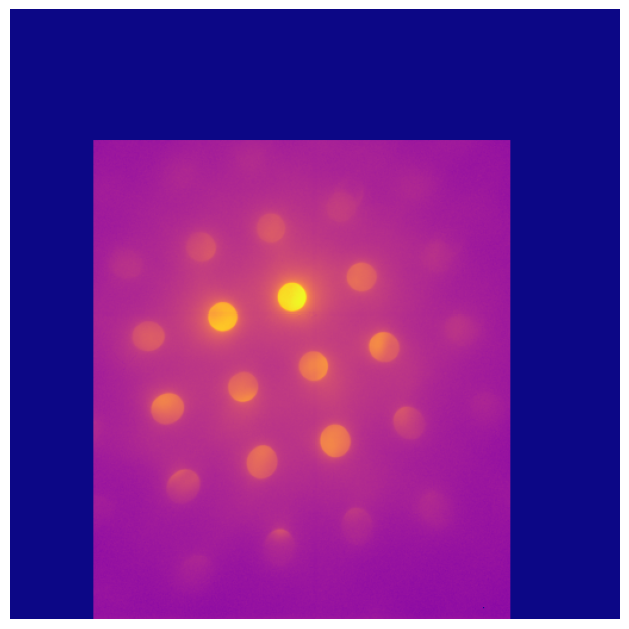

In [4]:
N_x, N_y = distorted_cbed_pattern_signal.data.shape

L = 70
R = N_x-420
B = N_y-512
T = 110

distorted_cbed_pattern_signal.data[:, :L] = 0
distorted_cbed_pattern_signal.data[:, N_x-R:] = 0
distorted_cbed_pattern_signal.data[:T, :] = 0
distorted_cbed_pattern_signal.data[N_y-B:, :] = 0



kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
distorted_cbed_pattern_signal.plot(**kwargs)

We found that masking can improve the performance of our DL model. One possible
explanation is that at low beam energies and small CBED disk sizes, the Ewald
sphere curvature can be quite pronounced and the small-angle approximation may
not hold across the entire angular field of view of a given CBED pattern, both
of which may affect the validity of our assumption that the CBED pattern should
depict only near-perfect circular CBED disks of the same common radius, in the
absence of distortion. This should only be a concern at larger scattering
angles, which is why we did not mask most of the ZOLZ reflections.

## Estimating the distortion in the CBED pattern ##

Now let's load a ML model so that we can estimate the distortion in the CBED
pattern:

In [5]:
path_to_ml_model_state_dicts = path_to_data_dir + "/ml_models/ml_model_1"
pattern = r"ml_model_at_lr_step_[0-9]*\.pth"
largest_lr_step_idx = max([name.split("_")[-1].split(".")[0]
                           for name in os.listdir(path_to_ml_model_state_dicts)
                           if re.fullmatch(pattern, name)])

ml_model_state_dict_filename = \
    (path_to_ml_model_state_dicts
     + "/ml_model_at_lr_step_{}.pth".format(largest_lr_step_idx))



module_alias = emicroml.modelling.cbed.distortion.estimation
kwargs = {"ml_model_state_dict_filename": ml_model_state_dict_filename,
          "device_name": None}  # Default to CUDA device if available.
ml_model = module_alias.load_ml_model_from_file(**kwargs)

_ = ml_model.eval()

With the ML model loaded, let's estimate the distortion in the CBED pattern:

In [6]:
sampling_grid_dims_in_pixels = distorted_cbed_pattern_image.shape
distorted_cbed_pattern_images = distorted_cbed_pattern_image[None, :, :]

kwargs = {"cbed_pattern_images": distorted_cbed_pattern_images,
          "sampling_grid_dims_in_pixels": sampling_grid_dims_in_pixels}
distortion_models = ml_model.predict_distortion_models(**kwargs)

distortion_model = distortion_models[0]

Note that any input distorted CBED pattern must have image dimensions, in units
of pixels, equal to
``2*(ml_model.core_attrs["num_pixels_across_each_cbed_pattern"],)``. This is
because a given ML model is trained for images of fixed dimensions, in units of
pixels.

Let's visualize the predicted distortion field:

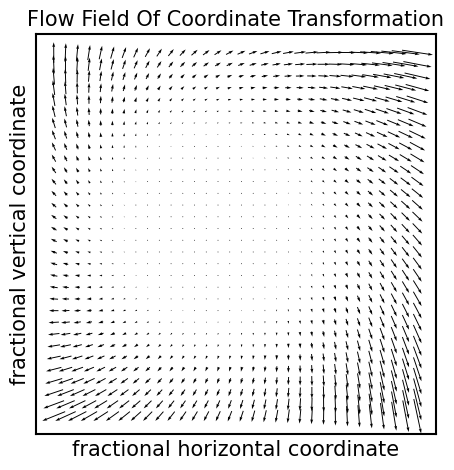

In [7]:
kwargs = {"sampling_grid": distortion_model.sampling_grid,
          "flow_field": distortion_model.flow_field_of_coord_transform}
helpers.visualize_flow_field(**kwargs)

## Correcting the distortion in the SAED pattern ##

Let's use the predicted distortion model to correct the distortion in the SAED
pattern:

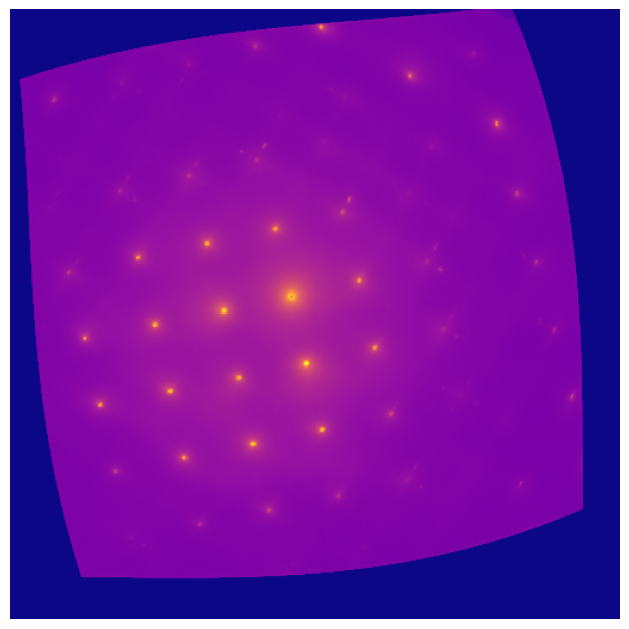

In [8]:
kwargs = \
    {"distorted_images": distorted_saed_pattern_image[None, None, :, :]}
undistorted_then_resampled_images = \
    distortion_model.undistort_then_resample_images(**kwargs)

undistorted_saed_pattern_image = \
    undistorted_then_resampled_images[0, 0].numpy(force=True)



kwargs = {"data": undistorted_saed_pattern_image}
undistorted_saed_pattern_signal = hs.signals.Signal2D(**kwargs)



kwargs = {"axes_off": True, 
          "scalebar": False, 
          "colorbar": False, 
          "gamma": 0.2,
          "cmap": "plasma", 
          "title": ""}
undistorted_saed_pattern_signal.plot(**kwargs)

## Assessing the accuracy of the distortion correction ##

We know that the sample is single-crystal Au oriented in the \[100\] direction,
used for calibration. As such, in the absence of distortions, the zero-order
Laue zone (ZOLZ) reflections should lie approximately on a square lattice. We
say approximately because strictly speaking, the ZOLZ reflections furthest from
the direct beam should deviate from a square lattice by approximately 2 pixels,
due to the curvature of the Ewald sphere for a beam energy of 20
keV. Nevertheless, fitting square lattices to the most visible ZOLZ reflections
in both the distorted SAED pattern and the undistorted SAED pattern, and
comparing the errors of the fits, should be a reasonable way to assess the
accuracy of the distortion correction.

The first step is to locate the ZOLZ reflections that are sufficiently visible
in the SAED patterns. We can do this by applying masks and peak-finding
algorithms.

Let's locate the sufficiently visble ZOLZ reflections of the distorted SAED
pattern:

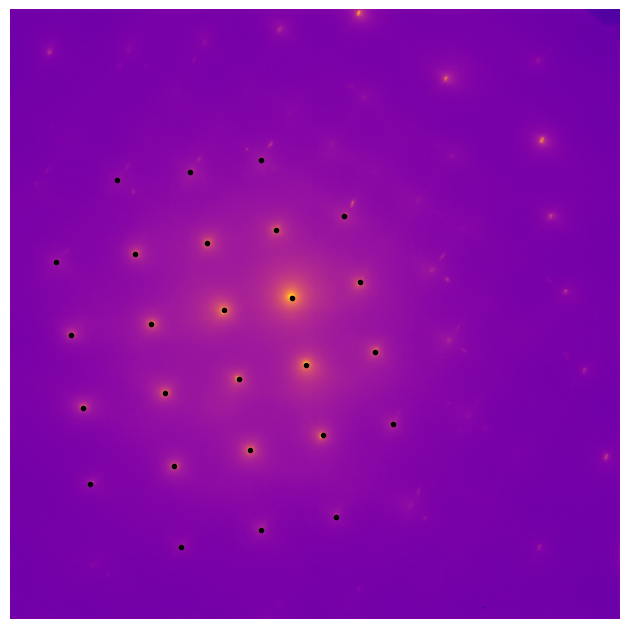

In [9]:
kwargs = \
    {"saed_pattern_signal": distorted_saed_pattern_signal}
zolz_reflection_selection_of_distorted_saed_pattern = \
    helpers.find_visible_zolz_reflections(**kwargs)

Now let's do the same for the undistorted SAED pattern:

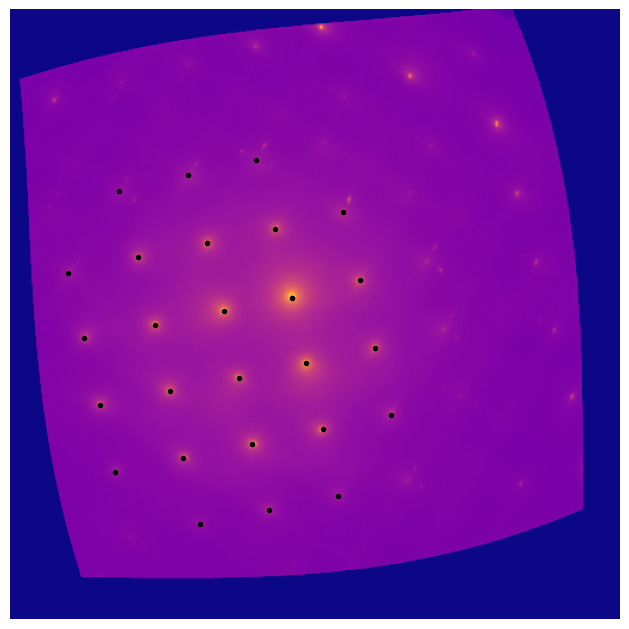

In [10]:
kwargs = \
    {"saed_pattern_signal": undistorted_saed_pattern_signal}
zolz_reflection_selection_of_undistorted_saed_pattern = \
    helpers.find_visible_zolz_reflections(**kwargs)

Now we need to perform the fits. The objective function that we will minimize is
the square root of the mean of the Euclidean distances squared between the ZOLZ
reflections and their corresponding points on the square lattice fit. We define
the fitting error to the final value of the objective function.

Let's perform the fit for the distorted SAED pattern, using the above function:

The error of the fit is: 0.009443903808075077, in units of the image width.


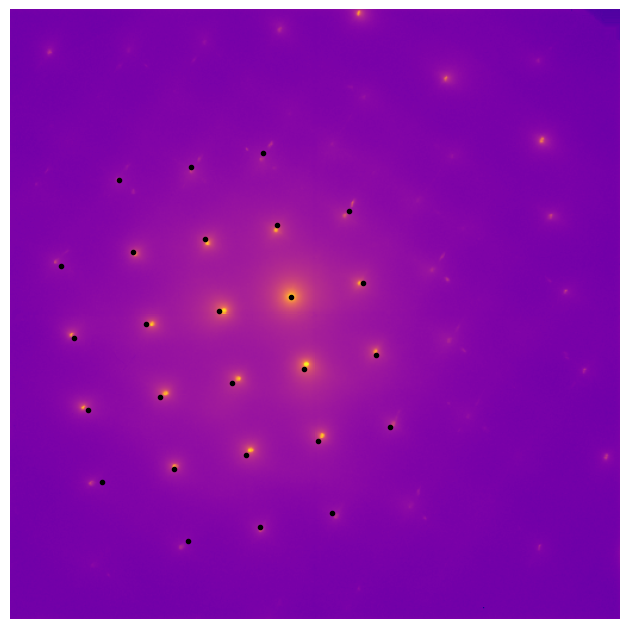

In [11]:
kwargs = {"visible_zolz_reflections": \
          zolz_reflection_selection_of_distorted_saed_pattern, 
          "saed_pattern_signal": \
          distorted_saed_pattern_signal}
_ = helpers.fit_visible_zolz_reflections_to_square_lattice(**kwargs)

The black dots in the figure directly above form the best square lattice fit to
the sufficiently visible ZOLZ reflections.

Now let's do the same fitting procedure for the undistorted SAED pattern:

The error of the fit is: 0.004622673319793057, in units of the image width.


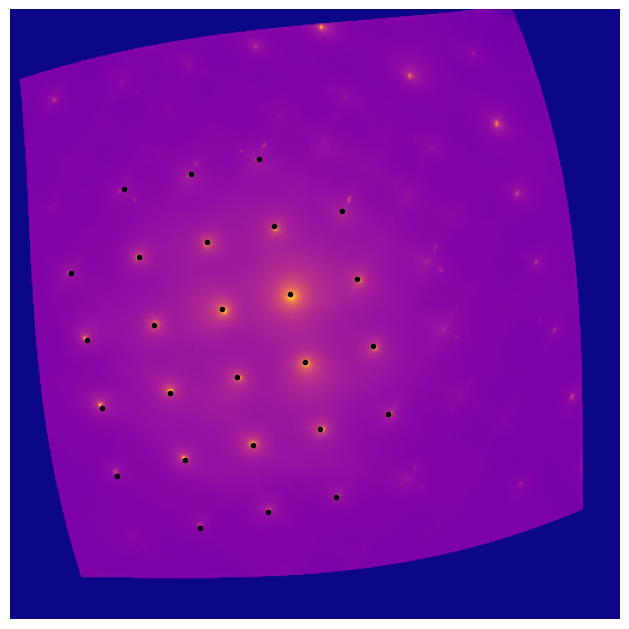

In [12]:
kwargs = {"visible_zolz_reflections": \
          zolz_reflection_selection_of_undistorted_saed_pattern, 
          "saed_pattern_signal": \
          undistorted_saed_pattern_signal}
_ = helpers.fit_visible_zolz_reflections_to_square_lattice(**kwargs)

As we can see both visually and from the lattice fit errors, our ML approach
corrects an appreciable amount of the distortion in the SAED pattern.